# Double/Debiased ML for Partially Linear IV Model

This is a simple implementation of Debiased Machine Learning for the Partially Linear
IV Regression Model, which provides an application of DML IV inference.


Reference:

- https://arxiv.org/abs/1608.00060
- https://www.amazon.com/Business-Data-Science-Combining-Accelerate/dp/1260452778

The code is based on the book.



# Partially Linear IV Model

We consider the partially linear structural equation model:
\begin{eqnarray}
 &  Y - D\theta_0 = g_0(X) + \zeta,  & E[\zeta \mid Z,X]= 0,\\
  & Z = m_0(X) +  V,   &  E[V \mid X] = 0.
\end{eqnarray}


Note that this model is not a regression model unless $Z=D$.  The model  is a canonical
model in causal inference, going back to P. Wright's work on IV methods for estimating demand/supply equations, with the modern difference being that $g_0$ and $m_0$ are nonlinear, potentially complicated functions of high-dimensional $X$.  


The idea of this model is that there is a structural or causal relation between $Y$ and $D$, captured by $\theta_0$, and $g_0(X) + \zeta$ is the stochastic error, partly explained by covariates $X$.  $V$ and $\zeta$ are stochastic errors that are not explained by $X$. Since $Y$ and $D$ are jointly determined, we need an external factor, commonly referred to as an instrument, $Z$ to create exogenous variation
in $D$.   Note that $Z$ should affect $D$.  The $X$ here serve again as confounding factors, so we can think of variation in $Z$ as being exogenous only conditional on $X$.


The causal DAG this model corresponds to is given by:
$$
Z \to D,  X \to (Y, Z, D),  L \to (Y,D),
$$
where $L$ is the latent confounder affecting both $Y$ and $D$, but not $Z$.



---

# Example

A simple contextual example is from biostatistics, where $Y$ is a health outcome and $D$ is indicator of smoking.  Thus, $\theta_0$ is captures the effect of smoking on health.  Health outcome $Y$ and smoking behavior $D$ are treated as being jointly determined.  $X$ represents patient characteristics, and $Z$ could be a doctor's advice not to smoke (or another behavioral treatment) that may affect the outcome $Y$ only through shifting the behavior $D$, conditional on characteristics $X$.   

----



# PLIVM in Residualized Form

The PLIV model above can be rewritten in the following residualized form:
$$
  \tilde Y = \tilde D \theta_0 + \zeta,   \quad  E[\zeta \mid V,X]= 0,
$$
where
$$
 \tilde Y = (Y- \ell_0(X)),  \quad \ell_0(X) = E[Y \mid X] \\
   \tilde D = (D - r_0(X)), \quad r_0(X) = E[D \mid X] \\
   \tilde Z = (Z- m_0(X)), \quad m_0(X) = E[Z \mid X].
$$
   The "tilde" variables (e.g. $\tilde Y$) above represent original variables after taking out or "partialling out"
  the effect of $X$.  Note that $\theta_0$ is identified from this equation if $V$
  and $U$ have non-zero correlation, which automatically means that $U$ and $V$
  must have non-zero variation.

  

-----

# DML for PLIV Model

Given identification, DML  proceeds as follows

Compute the estimates $\hat \ell_0$, $\hat r_0$, and $\hat m_0$ , which amounts
to solving the three problems of predicting $Y$, $D$, and $Z$ using
$X$, using any generic  ML method, giving us estimated residuals
$$
\tilde Y = Y - \hat \ell_0(X), \\ \tilde D= D - \hat r_0(X), \\ \tilde Z = Z- \hat m_0(X).
$$
The estimates should be of a cross-validated form, as detailed in the algorithm below.

Estimate $\theta_0$ by the the intstrumental
variable regression of $\tilde Y$ on $\tilde D$ using $\tilde Z$ as an instrument.
Use the conventional inference for the IV regression estimator, ignoring
the estimation error in these residuals.

The reason we work with this residualized form is that it eliminates the bias
arising when solving the prediction problem in stage 1. The role of cross-validation
is to avoid another source of bias due to potential overfitting.

The estimator is adaptive,
in the sense that the first stage estimation errors do not affect the second
stage errors.


In [1]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import patsy
import warnings
from sklearn.base import BaseEstimator
import statsmodels.api as sm
from statsmodels.tools import add_constant
warnings.simplefilter('ignore')
np.random.seed(1234)

In [2]:
def dml(X, Z, D, y, modely, modeld, modelz, *, nfolds, classifier=False):
    '''
    DML for the Partially Linear Model setting with cross-fitting

    Input
    -----
    X: the controls
    Z: the instrument
    D: the treatment
    y: the outcome
    modely: the ML model for predicting the outcome y
    modeld: the ML model for predicting the treatment D
    modelz: the ML model for predicting the instrument Z
    nfolds: the number of folds in cross-fitting
    classifier: bool, whether the modeld is a classifier or a regressor

    Output
    ------
    point: the point estimate of the treatment effect of D on y
    stderr: the standard error of the treatment effect
    yhat: the cross-fitted predictions for the outcome y
    Dhat: the cross-fitted predictions for the treatment D
    Zhat: the cross-fitted predictions for the instrument Z
    resy: the outcome residuals
    resD: the treatment residuals
    resZ: the instrument residuals
    epsilon: the final residual-on-residual OLS regression residual
    '''
    cv = KFold(n_splits=nfolds, shuffle=True, random_state=123)  # shuffled k-folds
    yhat = cross_val_predict(modely, X, y, cv=cv, n_jobs=-1)  # out-of-fold predictions for y
    # out-of-fold predictions for D
    # use predict or predict_proba dependent on classifier or regressor for D
    if classifier:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
        Zhat = cross_val_predict(modelz, X, Z, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
    else:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, n_jobs=-1)
        Zhat = cross_val_predict(modelz, X, Z, cv=cv, n_jobs=-1)
    # calculate outcome and treatment residuals
    resy = y - yhat
    resD = D - Dhat
    resZ = Z - Zhat
    # rename for downstream tasks
    resy = resy.rename("resy")
    resD = resD.rename("resD")
    resZ = resZ.rename("resZ")

    # final stage ols based point estimate and standard error
    point = np.mean(resy * resZ) / np.mean(resD * resZ)
    epsilon = resy - point * resD
    var = np.mean(epsilon**2 * resZ**2) / np.mean(resD * resZ)**2
    stderr = np.sqrt(var / X.shape[0])
    return point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, epsilon

In [3]:
def summary(point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, epsilon, X, D, Z, y, *, name):
    '''
    Convenience summary function that takes the results of the DML IV function
    and summarizes several estimation quantities and performance metrics.
    '''
    return pd.DataFrame({'estimate': point,  # point estimate
                         'stderr': stderr,  # standard error
                         'lower': point - 1.96 * stderr,  # lower end of 95% confidence interval
                         'upper': point + 1.96 * stderr,  # upper end of 95% confidence interval
                         'rmse y': np.sqrt(np.mean(resy**2)),  # RMSE of model that predicts outcome y
                         'rmse Z': np.sqrt(np.mean(resZ**2)),  # RMSE of model that predicts instrument Z
                         'rmse D': np.sqrt(np.mean(resD**2))  # RMSE of model that predicts treatment D
                         }, index=[name])

-----


# Emprical Example:  Acemoglu, Johnson, Robinson (AER).

* Y is log GDP;
* D is a measure of Protection from Expropriation, a proxy for
quality of insitutions;
* Z is the log of Settler's mortality;
* W are geographical variables (latitude, latitude squared, continent dummies as well as interactions)



In [4]:
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/AJR.csv"
data = pd.read_csv(file)
data.shape

(64, 11)

Run the following command to install hdmpy for rigorous lasso:

``` !pip install multiprocess ```


```!git clone https://github.com/maxhuppertz/hdmpy.git ```

In [5]:
!pip install multiprocess
!git clone https://github.com/maxhuppertz/hdmpy.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.3 MB/s eta 0:00:00
Cloning into 'hdmpy'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 70 (delta 39), reused 52 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 25.30 KiB | 2.53 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [6]:
import hdmpy


class RLasso(BaseEstimator):

    def __init__(self, *, post=True):
        self.post = post

    def fit(self, X, y):
        self.rlasso_ = hdmpy.rlasso(X, y, post=self.post)
        return self

    def predict(self, X):
        return np.array(X) @ np.array(self.rlasso_.est['beta']).flatten() + np.array(self.rlasso_.est['intercept'])

In [7]:
y = data['GDP']
d = data['Exprop']
z = data['logMort']

controls = data.drop(['GDP', 'Exprop', 'logMort'], axis=1)
x = patsy.dmatrix('-1 + (Latitude + Latitude2 + Africa + Asia + Namer + Samer)**2',
                  data=controls, return_type='dataframe')

In [8]:
# DML with Post-Lasso:
modely = make_pipeline(StandardScaler(), RLasso(post=True))
modeld = make_pipeline(StandardScaler(), RLasso(post=True))
modelz = make_pipeline(StandardScaler(), RLasso(post=True))

# Run DML model with nfolds folds of cross-fitting
res_rlasso = dml(x, z, d, y, modely, modeld, modelz, nfolds=5)
table_rlasso = summary(*res_rlasso, x, d, z, y, name='RLasso')

In [9]:
# DML with Random Forests. RFs don't require scaling but we do it for consistency
modely = make_pipeline(StandardScaler(),
                       RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=1234))
modeld = make_pipeline(StandardScaler(),
                       RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=1234))
modelz = make_pipeline(StandardScaler(),
                       RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=1234))

# Run DML model with nfolds folds of cross-fitting (computationally intensive)
res_RF = dml(x, z, d, y, modely, modeld, modelz, nfolds=5)
table_RF = summary(*res_RF, x, d, z, y, name='RF')

In [10]:
results = pd.concat([table_rlasso, table_RF], axis=0)
results

,estimate,stderr,lower,upper,rmse y,rmse Z,rmse D
RLasso,0.734376,0.176548,0.388342,1.080411,0.918707,1.087234,1.595225
RF,0.827029,0.328725,0.182728,1.471329,0.769921,1.040540,1.336038


# Weak Instruments?

In [11]:
# Summary for RLasso
resy_rlasso, resD_rlasso, resZ_rlasso = res_rlasso[5], res_rlasso[6], res_rlasso[7]
# Using HC3 robust standard errors
regDZ_rlasso = sm.OLS(resD_rlasso, add_constant(resZ_rlasso)).fit(cov_type='HC3', use_t=True)
print(regDZ_rlasso.summary())

# Summary for RF
resy_RF, resD_RF, resZ_RF = res_RF[5], res_RF[6], res_RF[7]
# Using HC3 robust standard errors
regDZ_RF = sm.OLS(resD_RF, add_constant(resZ_RF)).fit(cov_type='HC3', use_t=True)
print(regDZ_RF.summary())

                            OLS Regression Results                            
Dep. Variable:                   resD   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     8.828
Date:                Thu, 06 Feb 2025   Prob (F-statistic):            0.00422
Time:                        06:41:01   Log-Likelihood:                -114.17
No. Observations:                  64   AIC:                             232.3
Df Residuals:                      62   BIC:                             236.7
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0306      0.187     -0.164      0.8

## Anderson-Rubin Idea for Inference with Weak Instruments

As shown above, we may have weak instruments because the t-stat in the regression $\tilde D \sim \tilde Z$ is small relative to standard rules of thumb -- for example Stock and Yogo (2005) suggest accounting for weak instruments if the first stage F-statistic is less than 10 (and more recent work suggests even larger cutoffs).


 Here, we consider one specific approach (from Anderson and Rubin (1949)) to doing valid inference under weak identification based upon the statistic:
$$
C(\theta) = \frac{ |E_n [(\tilde Y -  \theta  \tilde D) \tilde Z]|^2}{ \mathbb{V}_n [(\tilde Y -  \theta \tilde  D) \tilde Z ]/n}.
$$
The empirical variance $\mathbb{V}_n$ is defined as:
\begin{align*}
\mathbb{V}_{n}[ g(W_i)] &:=   \mathbb{E}_{n}g(W_i)g(W_i)' - \mathbb{E}_{n}[ g(W_i)]\mathbb{E}_{n}[ g(W_i)]'.
\end{align*}

If $\theta_0 = \theta$, then $C(\theta) \overset{a}{\sim} N(0,1)^2 = \chi^2(1)$. Therefore,  we can reject the hypothesis $\theta_0 = \theta$ at level $a$ (for example $a = .05$ for a 5\% level test)  if $C(\theta)> c(1-a)$ where $c(1-a)$ is the $(1-a)$- quantile of a $\chi^2(1)$ variable.  The probability of falsely rejecting the true hypothesis is approximately $a \times 100\%$.  
To construct a $(1-a) \times 100$\% confidence region for $\theta$, we can then simply invert the test by collecting all parameter values that are not rejected at the $a$ level:
$$
CR(\theta) = \{ \theta \in \Theta: C(\theta)  \leq c(1-a)\}.
$$


In more complex settings with many controls or controls that enter with unknown functional form, we can simply replace the residuals $\tilde Y$, $\tilde D$, and $\tilde Z$ by machine
learned cross-fitted residuals $\check Y$, $\check D$, and $ \check Z$.  Thanks to the orthogonality of the IV moment condition underlying the formulation outlined above, we can formally assert that the properties of $C(\theta)$ and the subsequent testing procedure and confidence region for $\theta$ continue to hold when using cross-fitted residuals. We will further be able to apply the general procedure to cases where $D$
is a vector, with a suitable adjustment of the statistic $C(\theta)$.


So let's carry out DML inference combined with Anderson-Rubin Idea

In [12]:
from scipy.stats import chi2


def DML_AR_PLIV(rY, rD, rZ, grid, alpha=0.05):
    n = len(rY)
    Cstat = np.zeros(len(grid))

    for i in range(len(grid)):
        term1 = (rY - grid[i] * rD) * rZ
        Cstat[i] = n * (np.mean(term1))**2 / np.var(term1)

    Cstat = np.nan_to_num(Cstat)  # Replace any NaNs with zeros

    lower_bound = min(grid[Cstat < chi2.ppf(1 - alpha, 1)])
    upper_bound = max(grid[Cstat < chi2.ppf(1 - alpha, 1)])

    plt.plot(grid, Cstat, linestyle='-', color='black')
    plt.axhline(y=chi2.ppf(1 - alpha, 1), linestyle='--', color='blue')
    plt.axvline(x=lower_bound, linestyle='--', color='red')
    plt.axvline(x=upper_bound, linestyle='--', color='red')
    plt.xlabel('Effect of institutions')
    plt.ylabel('Statistic')
    plt.title('')
    plt.show()

    return {'UB': upper_bound, 'LB': lower_bound}

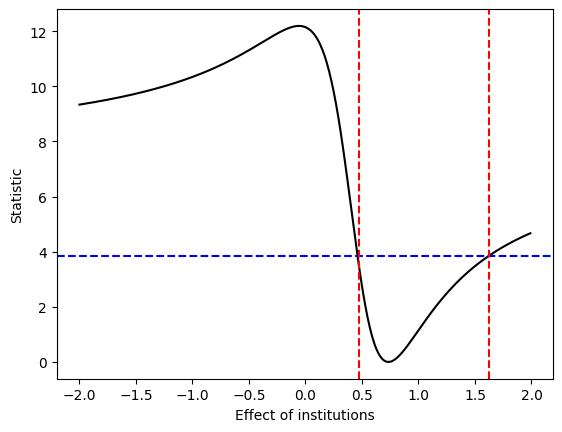

RLasso UB and LB:  {'UB': 1.6200000000000032, 'LB': 0.4700000000000024}


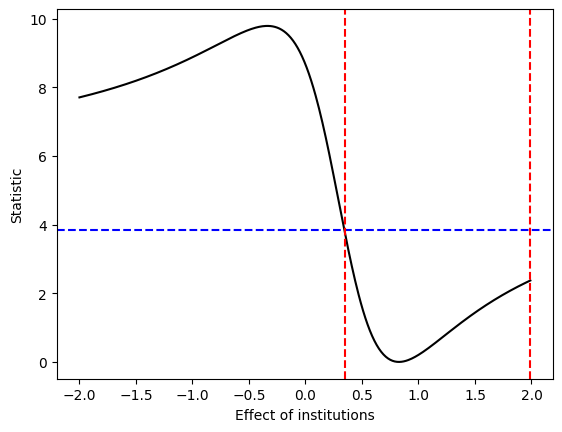

RF UB and LB:  {'UB': 1.9900000000000038, 'LB': 0.3500000000000023}


In [13]:
# Using RLasso
dml_ar_rlasso = DML_AR_PLIV(rY=resy_rlasso, rD=resD_rlasso, rZ=resZ_rlasso, grid=np.arange(-2, 2, 0.01))
print("RLasso UB and LB: ", dml_ar_rlasso)
# Using RF
dml_ar_RF = DML_AR_PLIV(rY=resy_RF, rD=resD_RF, rZ=resZ_RF, grid=np.arange(-2, 2, 0.01))
print("RF UB and LB: ", dml_ar_RF)